In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

# Some warnings can be ignored in the produced notebook.
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# RuuviTag data-analytics
Analyzed and visualized [RuuviTag](https://ruuvi.com/ruuvitag/) data from my home from 2023.

I made Iot-project related to my studies in november 2022. Check out the project via [this](https://student.labranet.jamk.fi/~aa5348/Iot_johdanto/Iot-projekti.html) link.

Data has been collected for a year now and it's time to look at what temperatures, humidity and air pressure values have been in my home in 2023.

This data analytics project tries to adapt the crisp-dm model where applicable.

## 1. Business understanding

In a summary from my project. I have three RuuviTag sensors in my house collecting temperature, humidity and air pressure values. One of them is in bathroom, one is in living room and one is in bedroom.

I don't have specific goals in this project. Mainly I am curious what kind on data I have collected. Also it is nice to know what is averager temperature for example in heating season.

With this data I can see how temperature and humidity chances by seasons, how many times I have been in shower or which is my favourite sauna day.

## 2. Data understanding

What kind of columns I have? How many nans? Is there something unnecessary information? Can I use data for the purposes I wanted?

I do this by summarizing statistical information and by visualizing data.

In [2]:
url = 'data/ruuvidata_2023_obfuscated.csv'
df = pd.read_csv(url)

Let's see what is the structure of dataset.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2344998 entries, 0 to 2344997
Data columns (total 11 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Unnamed: 0       int64  
 1   name             object 
 2   time             int64  
 3   battery          int64  
 4   humidity         float64
 5   location         object 
 6   mac              object 
 7   pressure         int64  
 8   sequenceCounter  float64
 9   temperature      float64
 10  txPower          float64
dtypes: float64(4), int64(4), object(3)
memory usage: 196.8+ MB


Okay, 10 columns and almost 2,4 million rows. 

In [4]:
display(df.tail())

,Unnamed: 0,name,time,battery,humidity,location,mac,pressure,sequenceCounter,temperature,txPower
2344993,2344993,msg.payload,1703937589000000000,2929,22.09,Pesuhuone,d7:58:ec:bb:bb:bb,99187,15581.0,21.80,-18.0
2344994,2344994,msg.payload,1703937591000000000,2988,24.20,Olohuone,d7:58:ec:cc:cc:cc,99168,20108.0,21.89,-18.0
2344995,2344995,msg.payload,1703937715000000000,2921,26.55,Makuuhuone,d7:58:ec:aa:aa:aa,99196,17598.0,19.32,-18.0
2344996,2344996,msg.payload,1703937717000000000,2992,24.13,Olohuone,d7:58:ec:cc:cc:cc,99178,20157.0,21.97,-18.0
2344997,2344997,msg.payload,1703937718000000000,2921,26.55,Makuuhuone,d7:58:ec:aa:aa:aa,99190,17599.0,19.29,-18.0


Pay attention to a few things.

- Every row is one measurement from a RuuviTag sensor.
- Dataset contains measurements from three different RuuviTag sensors.
- Name column is useless.
    - Drop it!
- Time format is strange? Do something about it.
    - I wish I could use time column as index column.
- Location column values are in finnish. Translate to english.
- Location column values correlate with mac-address, because I know that location is determined by mac-address.
    - I can drop mac- column.
- [SequenceCounter](https://f.ruuvi.com/t/how-to-interpret-ruuvitag-sensor-values/4339/6) is an ever-increasing counter until it reaches 65536 *(2^16)* and wraps around restarting from zero. It counts how much sensors is moved. RuuviTag also reboots the SequenceCounter when it reboots. Tag will reboot itself if battery is too low. This information can be used to get information when change the battery.

Let's see if there is nan values.

In [5]:
df.isna().sum()

Unnamed: 0            0
name                  0
time                  0
battery               0
humidity              0
location           2311
mac                   0
pressure              0
sequenceCounter    2362
temperature           0
txPower            2362
dtype: int64

In [6]:
#df[df['sequenceCounter'].isna()]

In location column is nans for over 2000 rows. Well it's good that I have all mac-values. With that I will fill location values because RuuviTag sensor with unique mac-address is standing in one of three rooms.

Let's see how visualization of nans looks like.

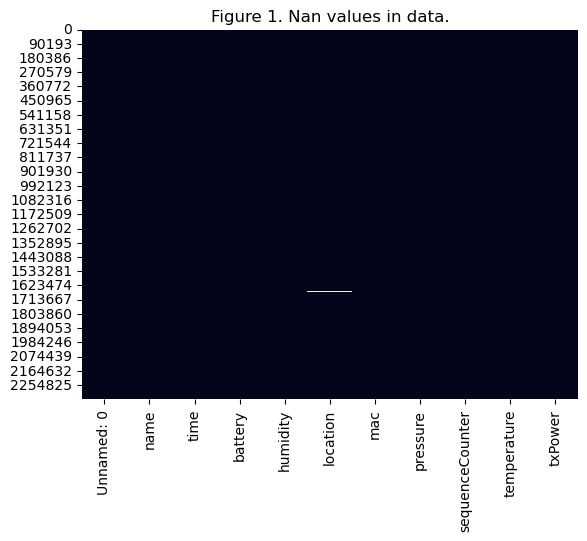

In [7]:
sns.heatmap(df.isna(), cbar=False)
plt.title('Figure 1. Nan values in data.')
plt.show()

As we can see there is not many nan -values in data. 2000 rows in 2 000 000 row is only a thousandth of entire data. I could delete it and it wont affect much for my analytics. But I decide to fill nans in location column because it is easy to do and it's good practice.

Also there is time period where is a lot of missing values. If I don't fill values in location column that timeperiod might appear as outlier when I visualize data.

**What kind of different values is in location column?**

In [8]:
df['location'].unique()

array([nan, 'Olohuone', 'Pesuhuone', 'Makuuhuone'], dtype=object)

Values are Finnish and they represent different rooms.

**How about unique mac values?**

In [9]:
df['mac'].unique()

array(['d7:58:ec:aa:aa:aa', 'd7:58:ec:bb:bb:bb', 'd7:58:ec:cc:cc:cc'],
      dtype=object)

Jep. At this point I know that location is important value so as I mentioned earlier I fill all Nans in location column by information which mac column will give me. Also it is better to rename location columns finnish values with english versions.

So before dropping mac column I will use it to fill location columns nans. That I will do in the next phase, Data preprocessing.

### Count of measurements by sensor

d7:58:ec:cc:cc:cc    1091155
d7:58:ec:aa:aa:aa     642088
d7:58:ec:bb:bb:bb     611755
Name: count, dtype: int64


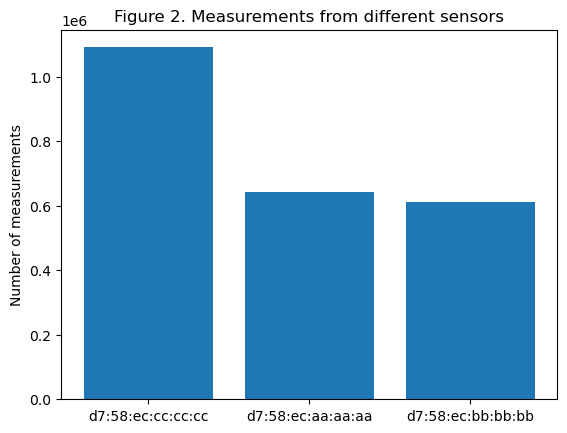

In [10]:
# Count sensors measurements to new dataframe.
df_measurements = df['mac'].value_counts()
# Change index names
df_measurements.index = ['d7:58:ec:cc:cc:cc','d7:58:ec:aa:aa:aa','d7:58:ec:bb:bb:bb']
print(df_measurements)

# barplot from sensors and measurements
plt.bar(df_measurements.index, df_measurements)
plt.ylabel('Number of measurements')
plt.title('Figure 2. Measurements from different sensors')

plt.show()

By figure 2. sensor c collected allmost half as many measurements than sensors a and b. 

I know that all sensors have the same configurations. This raises a question... Why?

Why count measurements from different sensors differ so much?

Sensors use bluetooth connection. Everybody know that ble-connection drops quickly. If you are using bluetooth headphones with you phone and forget phone on the other side of your house you notice that connection drops and you have to return to pick you phone :) That might be the reason for this... So let's see where sensors are located. 

### 2.1 Sharing data per sensor...

In order to find out which sensor is located in which room, the data must be divided into its own dataframes per sensor. Also this have to be made before analyzing data per sensor OR in practice analyzing temperature or humidity per room...

#### Sensor A

In [11]:
# New dataframe with only a- sensors data.
df_a = df[df['mac'] == 'd7:58:ec:aa:aa:aa'].copy()

In [12]:
df_a['location'].unique()

array([nan, 'Makuuhuone', 'Pesuhuone', 'Olohuone'], dtype=object)

**Wow!** There should be only nans and correct value from one room. But there is all possible location values!

Let's count different values in sensor-A column 'location'.

In [13]:
df_a['location'].value_counts()

location
Makuuhuone    641181
Olohuone           6
Pesuhuone          5
Name: count, dtype: int64

As we see sensor-A is "makuuhuone". For a some reason there is also wrong location values. I should delete these wrong values from data. I don't know reason for this. 

#### Sensor B

In [14]:
# New dataframe with only b- sensors data.
df_b = df[df['mac'] == 'd7:58:ec:bb:bb:bb'].copy()
df_b['location'].unique()
df_b['location'].value_counts()

location
Pesuhuone     611361
Olohuone           4
Makuuhuone         4
Name: count, dtype: int64

Sensor B is in "Pesuhuone". 

#### Sensor C

In [15]:
# New dataframe with only a- sensors data.
df_c = df[df['mac'] == 'd7:58:ec:cc:cc:cc'].copy()
df_c['location'].unique()
df_c['location'].value_counts()

location
Olohuone      1090118
Makuuhuone          4
Pesuhuone           4
Name: count, dtype: int64

Sensor C is in "Olohuone".

#### Notes

Same problem with wrong location values rises for every sensor. Don't know reason for this...

I know that RaspberryPi that receives ble transmission is located in the second floor of my house. It is located just above the living room = "Olohuone" where is sencor C.

Sensors A and B are located in first flood but on the other side of the house. It is possible that transmission from those sensors fades out. I remember this problem when I installed sensors.

I think this is the reason for different number of measurements from different sensors... Half of sensors A and B transmissions fade away... Propably :D

### Summary of statistic

#### Sensor A - Bed room

In [16]:
df_a.describe()

,Unnamed: 0,time,battery,humidity,pressure,sequenceCounter,temperature,txPower
count,6.420880e+05,6.420880e+05,642088.000000,642088.000000,642088.000000,641248.000000,642088.000000,641248.0
mean,1.222214e+06,1.688907e+18,2951.471166,39.696692,99976.231761,32600.329138,20.343553,-18.0
std,6.953399e+05,9.228596e+15,29.706681,12.939295,1267.701094,19053.710629,1.774536,0.0
min,0.000000e+00,1.668699e+18,2798.000000,15.350000,95998.000000,0.000000,14.760000,-18.0
25%,5.895600e+05,1.680444e+18,2932.000000,29.360000,99166.000000,15980.000000,19.090000,-18.0
50%,1.274052e+06,1.689616e+18,2957.000000,35.960000,100057.000000,32575.500000,19.840000,-18.0
75%,1.840841e+06,1.697192e+18,2971.000000,51.650000,100890.000000,49134.000000,21.480000,-18.0
max,2.344997e+06,1.703938e+18,3122.000000,74.990000,102975.000000,65534.000000,26.860000,-18.0


#### Sensor B - Bath room

In [17]:
df_b.describe()

,Unnamed: 0,time,battery,humidity,pressure,sequenceCounter,temperature,txPower
count,6.117550e+05,6.117550e+05,611755.000000,611755.000000,611755.000000,611327.000000,611755.000000,611327.0
mean,1.181384e+06,1.688360e+18,2966.452598,35.894400,100072.056601,32654.388776,22.627836,-18.0
std,6.779336e+05,9.000172e+15,23.352907,12.883644,1226.556157,18730.244475,2.113421,0.0
min,1.200000e+02,1.672576e+18,2876.000000,13.350000,95991.000000,0.000000,17.250000,-18.0
25%,5.903960e+05,1.680455e+18,2950.000000,25.550000,99266.000000,16501.000000,21.380000,-18.0
50%,1.143230e+06,1.687925e+18,2971.000000,32.210000,100151.000000,32413.000000,22.300000,-18.0
75%,1.793064e+06,1.696592e+18,2981.000000,46.780000,100959.000000,48845.000000,23.380000,-18.0
max,2.344993e+06,1.703938e+18,3094.000000,80.550000,102968.000000,65534.000000,46.190000,-18.0


#### Sensor C - Living room

In [18]:
df_c.describe()

,Unnamed: 0,time,battery,humidity,pressure,sequenceCounter,temperature,txPower
count,1.091155e+06,1.091155e+06,1.091155e+06,1.091155e+06,1.091155e+06,1.090061e+06,1.091155e+06,1090061.0
mean,1.138262e+06,1.687791e+18,3.008445e+03,3.819163e+01,1.000955e+05,3.284578e+04,2.167942e+01,-18.0
std,6.633045e+05,8.807991e+15,1.099077e+01,1.372851e+01,1.226695e+03,1.894707e+04,1.033802e+00,0.0
min,1.210000e+02,1.672576e+18,2.957000e+03,1.762000e+01,9.597500e+04,0.000000e+00,1.817000e+01,-18.0
25%,5.828025e+05,1.680353e+18,3.002000e+03,2.691000e+01,9.932800e+04,1.632300e+04,2.095000e+01,-18.0
50%,1.113363e+06,1.687541e+18,3.009000e+03,3.345000e+01,1.002020e+05,3.302300e+04,2.148000e+01,-18.0
75%,1.679924e+06,1.695100e+18,3.016000e+03,5.102000e+01,1.009840e+05,4.925000e+04,2.220000e+01,-18.0
max,2.344996e+06,1.703938e+18,3.101000e+03,7.189000e+01,1.029520e+05,6.553400e+04,2.653000e+01,-18.0


### Visualize sensors temperature data

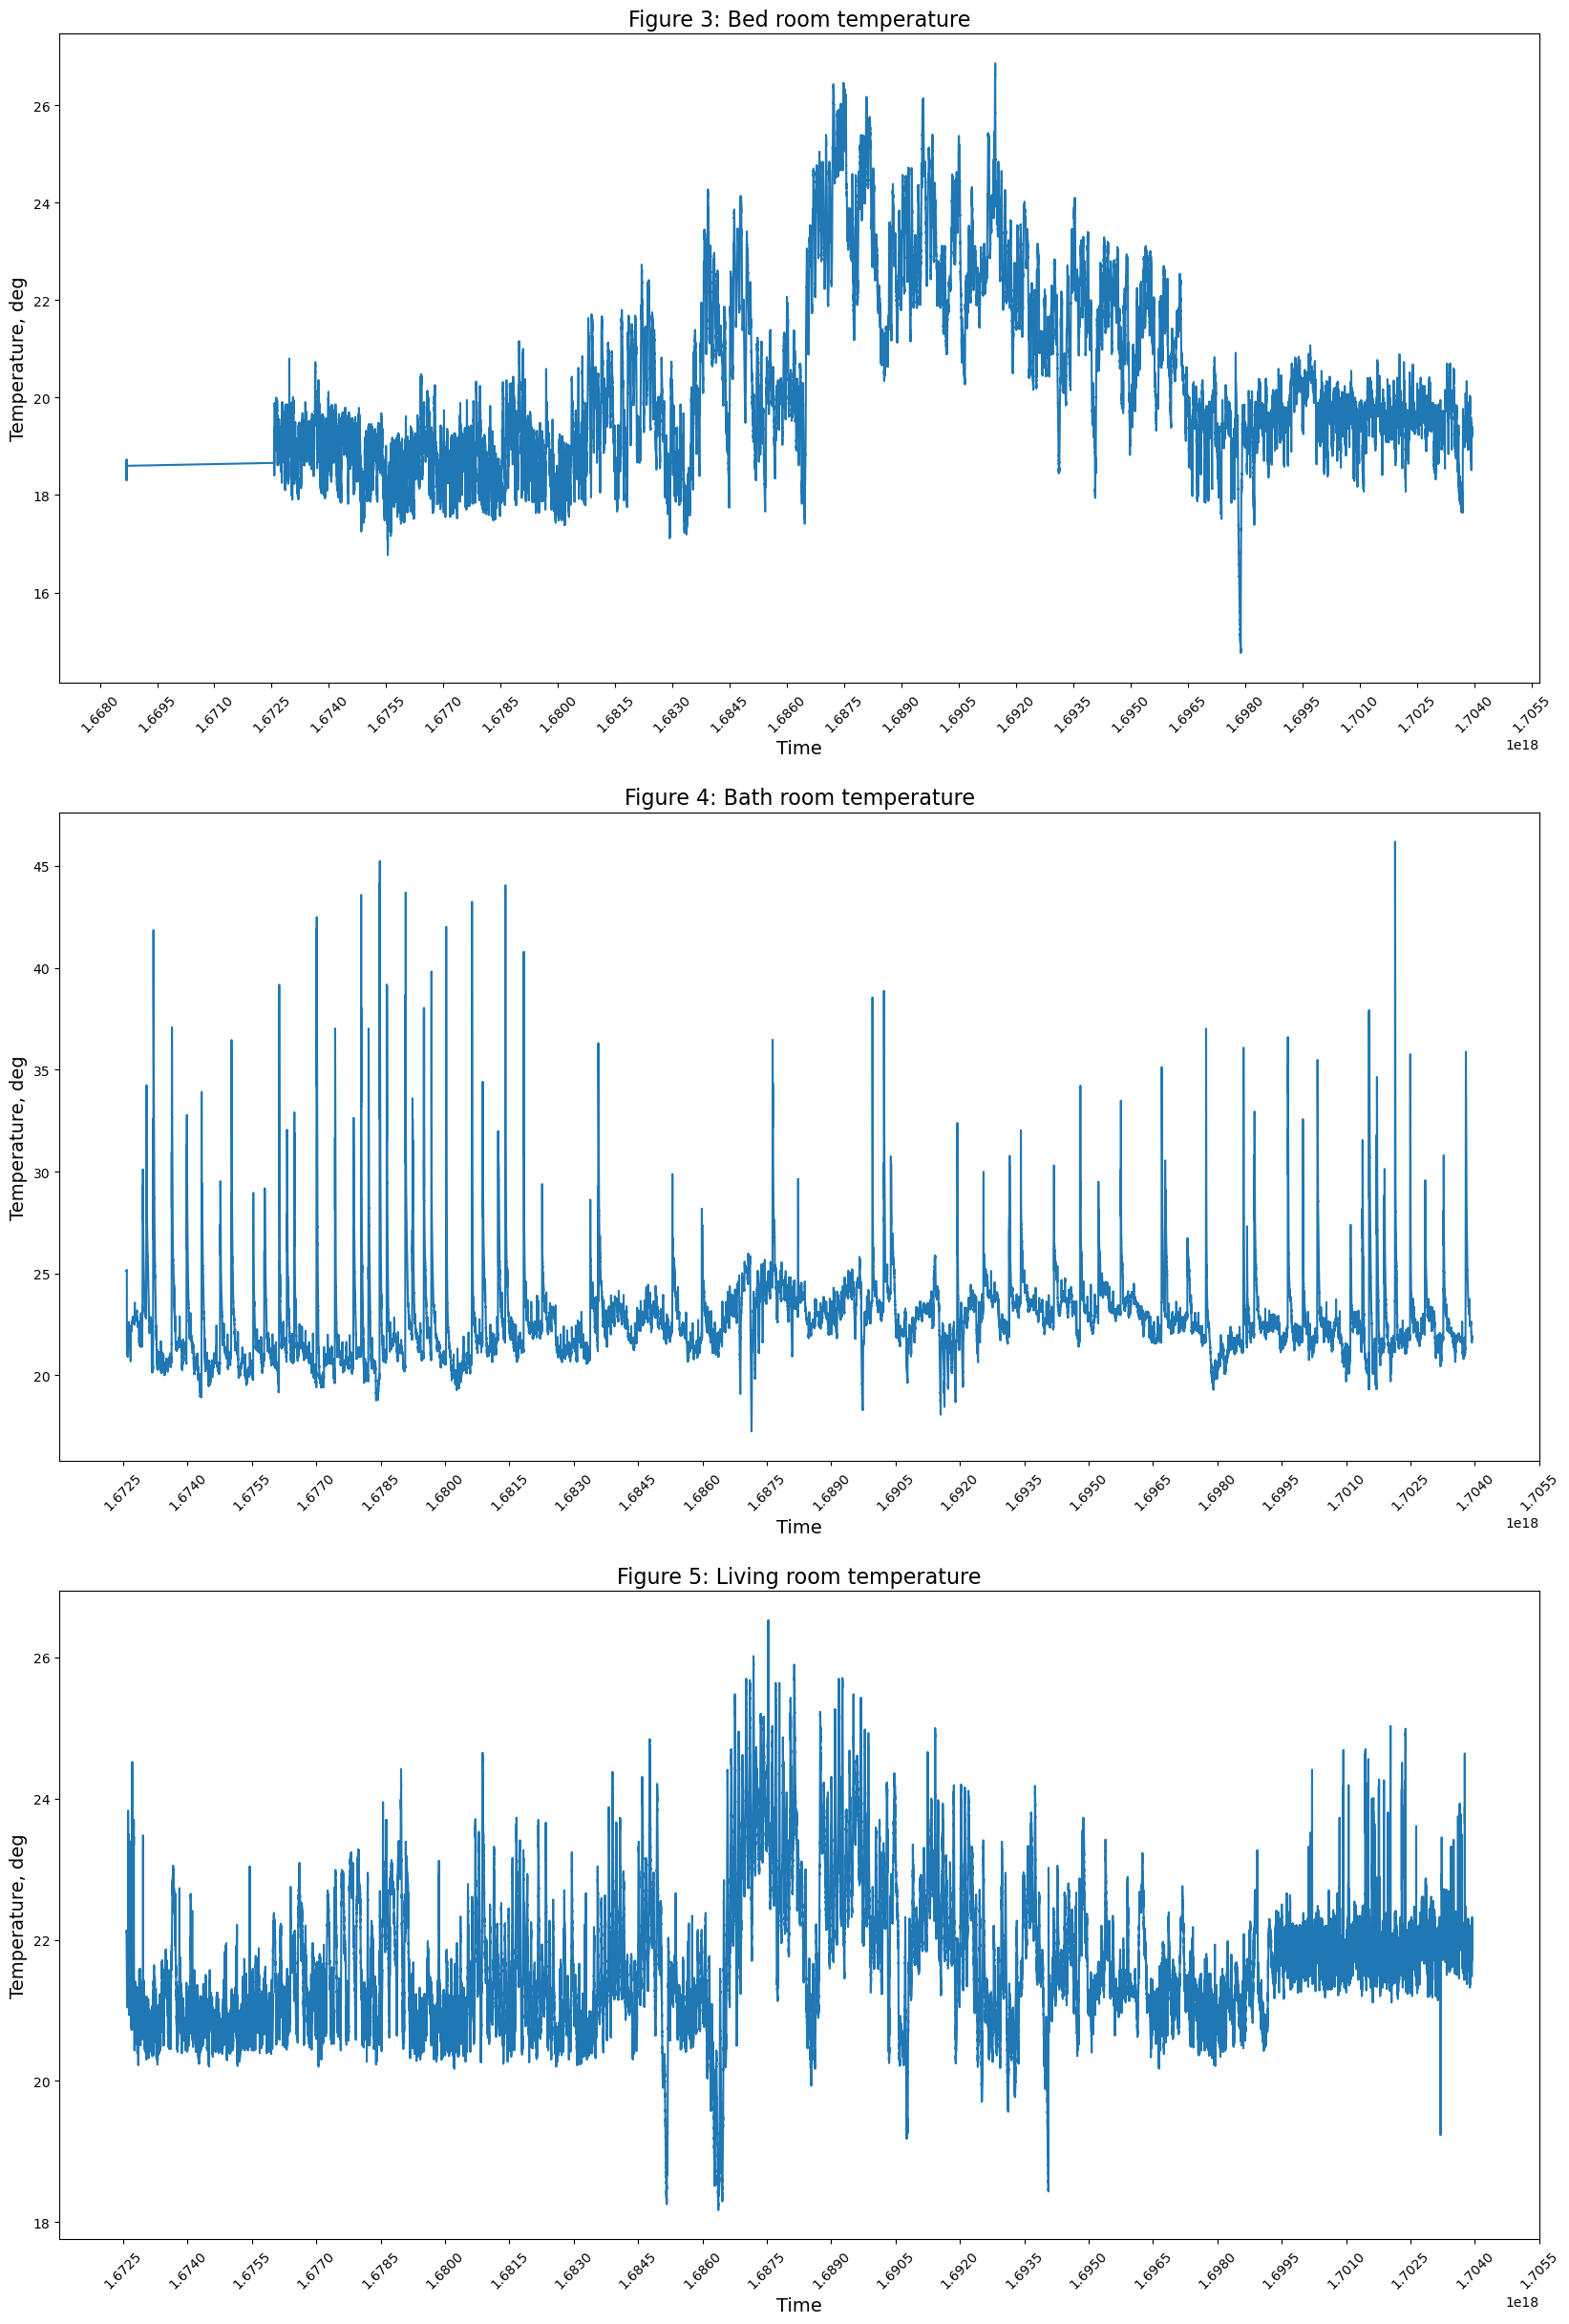

In [19]:
fig, ax = plt.subplots(3,1, figsize=(20, 30))

ax[0].plot(df_a['time'], df_a['temperature'])
ax[0].set_ylabel('Temperature, deg', size=14)
ax[0].set_xlabel('Time', size=14)
#ax[0].set_xlim('2012-01-01', '2015-12-31')
ax[0].set_title('Figure 3: Bed room temperature', size=16)
ax[0].xaxis.set_major_locator(plt.MaxNLocator(30))
ax[0].tick_params(axis='x', rotation=45)

ax[1].plot(df_b['time'], df_b['temperature'])
ax[1].set_ylabel('Temperature, deg', size=14)
ax[1].set_xlabel('Time', size=14)
#ax[1].set_xlim('2012-01-01', '2015-12-31')
ax[1].set_title('Figure 4: Bath room temperature', size=16)
ax[1].xaxis.set_major_locator(plt.MaxNLocator(30))
ax[1].tick_params(axis='x', rotation=45)

ax[2].plot(df_c['time'], df_c['temperature'])
ax[2].set_ylabel('Temperature, deg', size=14)
ax[2].set_xlabel('Time', size=14)
#ax[2].set_xlim('2012-01-01', '2015-12-31')
ax[2].set_title('Figure 5: Living room temperature', size=16)
ax[2].xaxis.set_major_locator(plt.MaxNLocator(30))
ax[2].tick_params(axis='x', rotation=45)


# Adjust layout
#plt.tight_layout()

plt.show()

Figures looks good.

When I look at these figures I understand many things about it that just make sense.

For example bed rooms temperature is lower than living rooms temperature. Also living rooms temperature is stable because there is air heat pump keeping stable temperature... and in bath room is high temperatures when sauna is heated or someone takes warm shower.

Great!

Next check what is in other columns.

### Visualize sensors humidity data

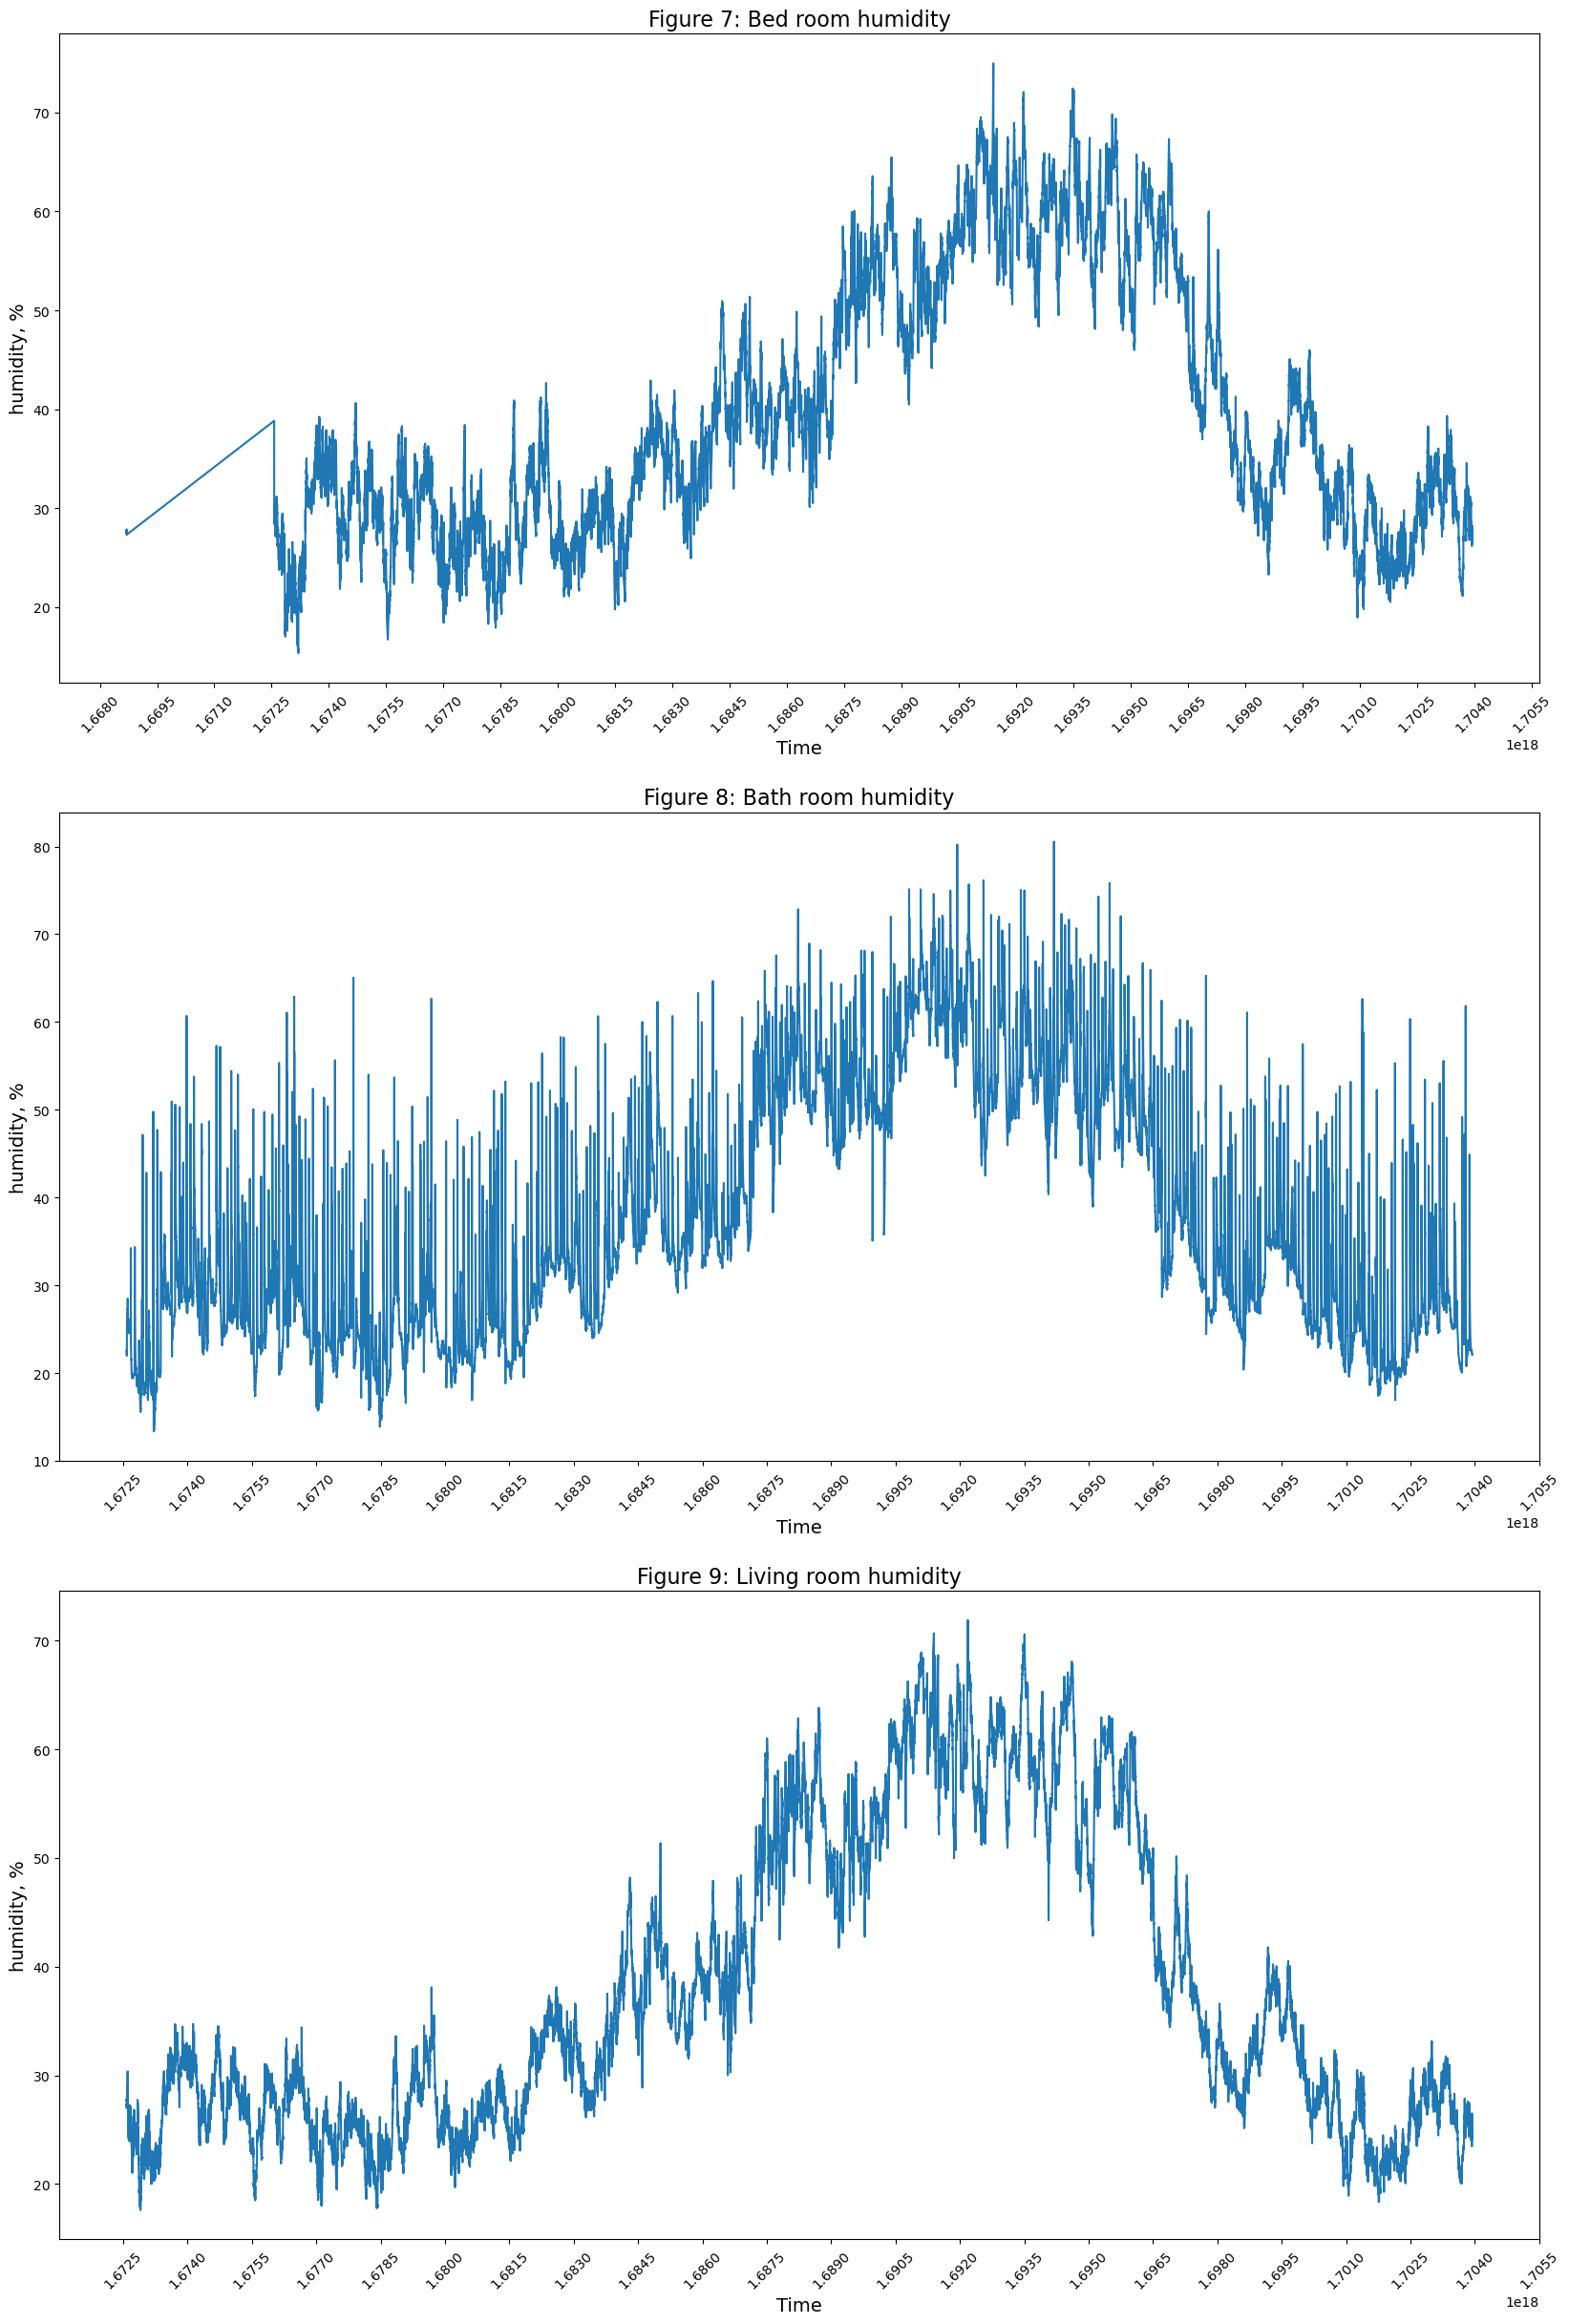

In [20]:
fig, ax = plt.subplots(3,1, figsize=(20, 30))

ax[0].plot(df_a['time'], df_a['humidity'])
ax[0].set_ylabel('humidity, %', size=14)
ax[0].set_xlabel('Time', size=14)
#ax[0].set_xlim('2012-01-01', '2015-12-31')
ax[0].set_title('Figure 7: Bed room humidity', size=16)
ax[0].xaxis.set_major_locator(plt.MaxNLocator(30))
ax[0].tick_params(axis='x', rotation=45)

ax[1].plot(df_b['time'], df_b['humidity'])
ax[1].set_ylabel('humidity, %', size=14)
ax[1].set_xlabel('Time', size=14)
#ax[1].set_xlim('2012-01-01', '2015-12-31')
ax[1].set_title('Figure 8: Bath room humidity', size=16)
ax[1].xaxis.set_major_locator(plt.MaxNLocator(30))
ax[1].tick_params(axis='x', rotation=45)

ax[2].plot(df_c['time'], df_c['humidity'])
ax[2].set_ylabel('humidity, %', size=14)
ax[2].set_xlabel('Time', size=14)
#ax[2].set_xlim('2012-01-01', '2015-12-31')
ax[2].set_title('Figure 9: Living room humidity', size=16)
ax[2].xaxis.set_major_locator(plt.MaxNLocator(30))
ax[2].tick_params(axis='x', rotation=45)


# Adjust layout
#plt.tight_layout()

plt.show()

Humidity varies with seasons. Also in bath room it varies daily because of showers etc...

### Visualize sensors air pressure data

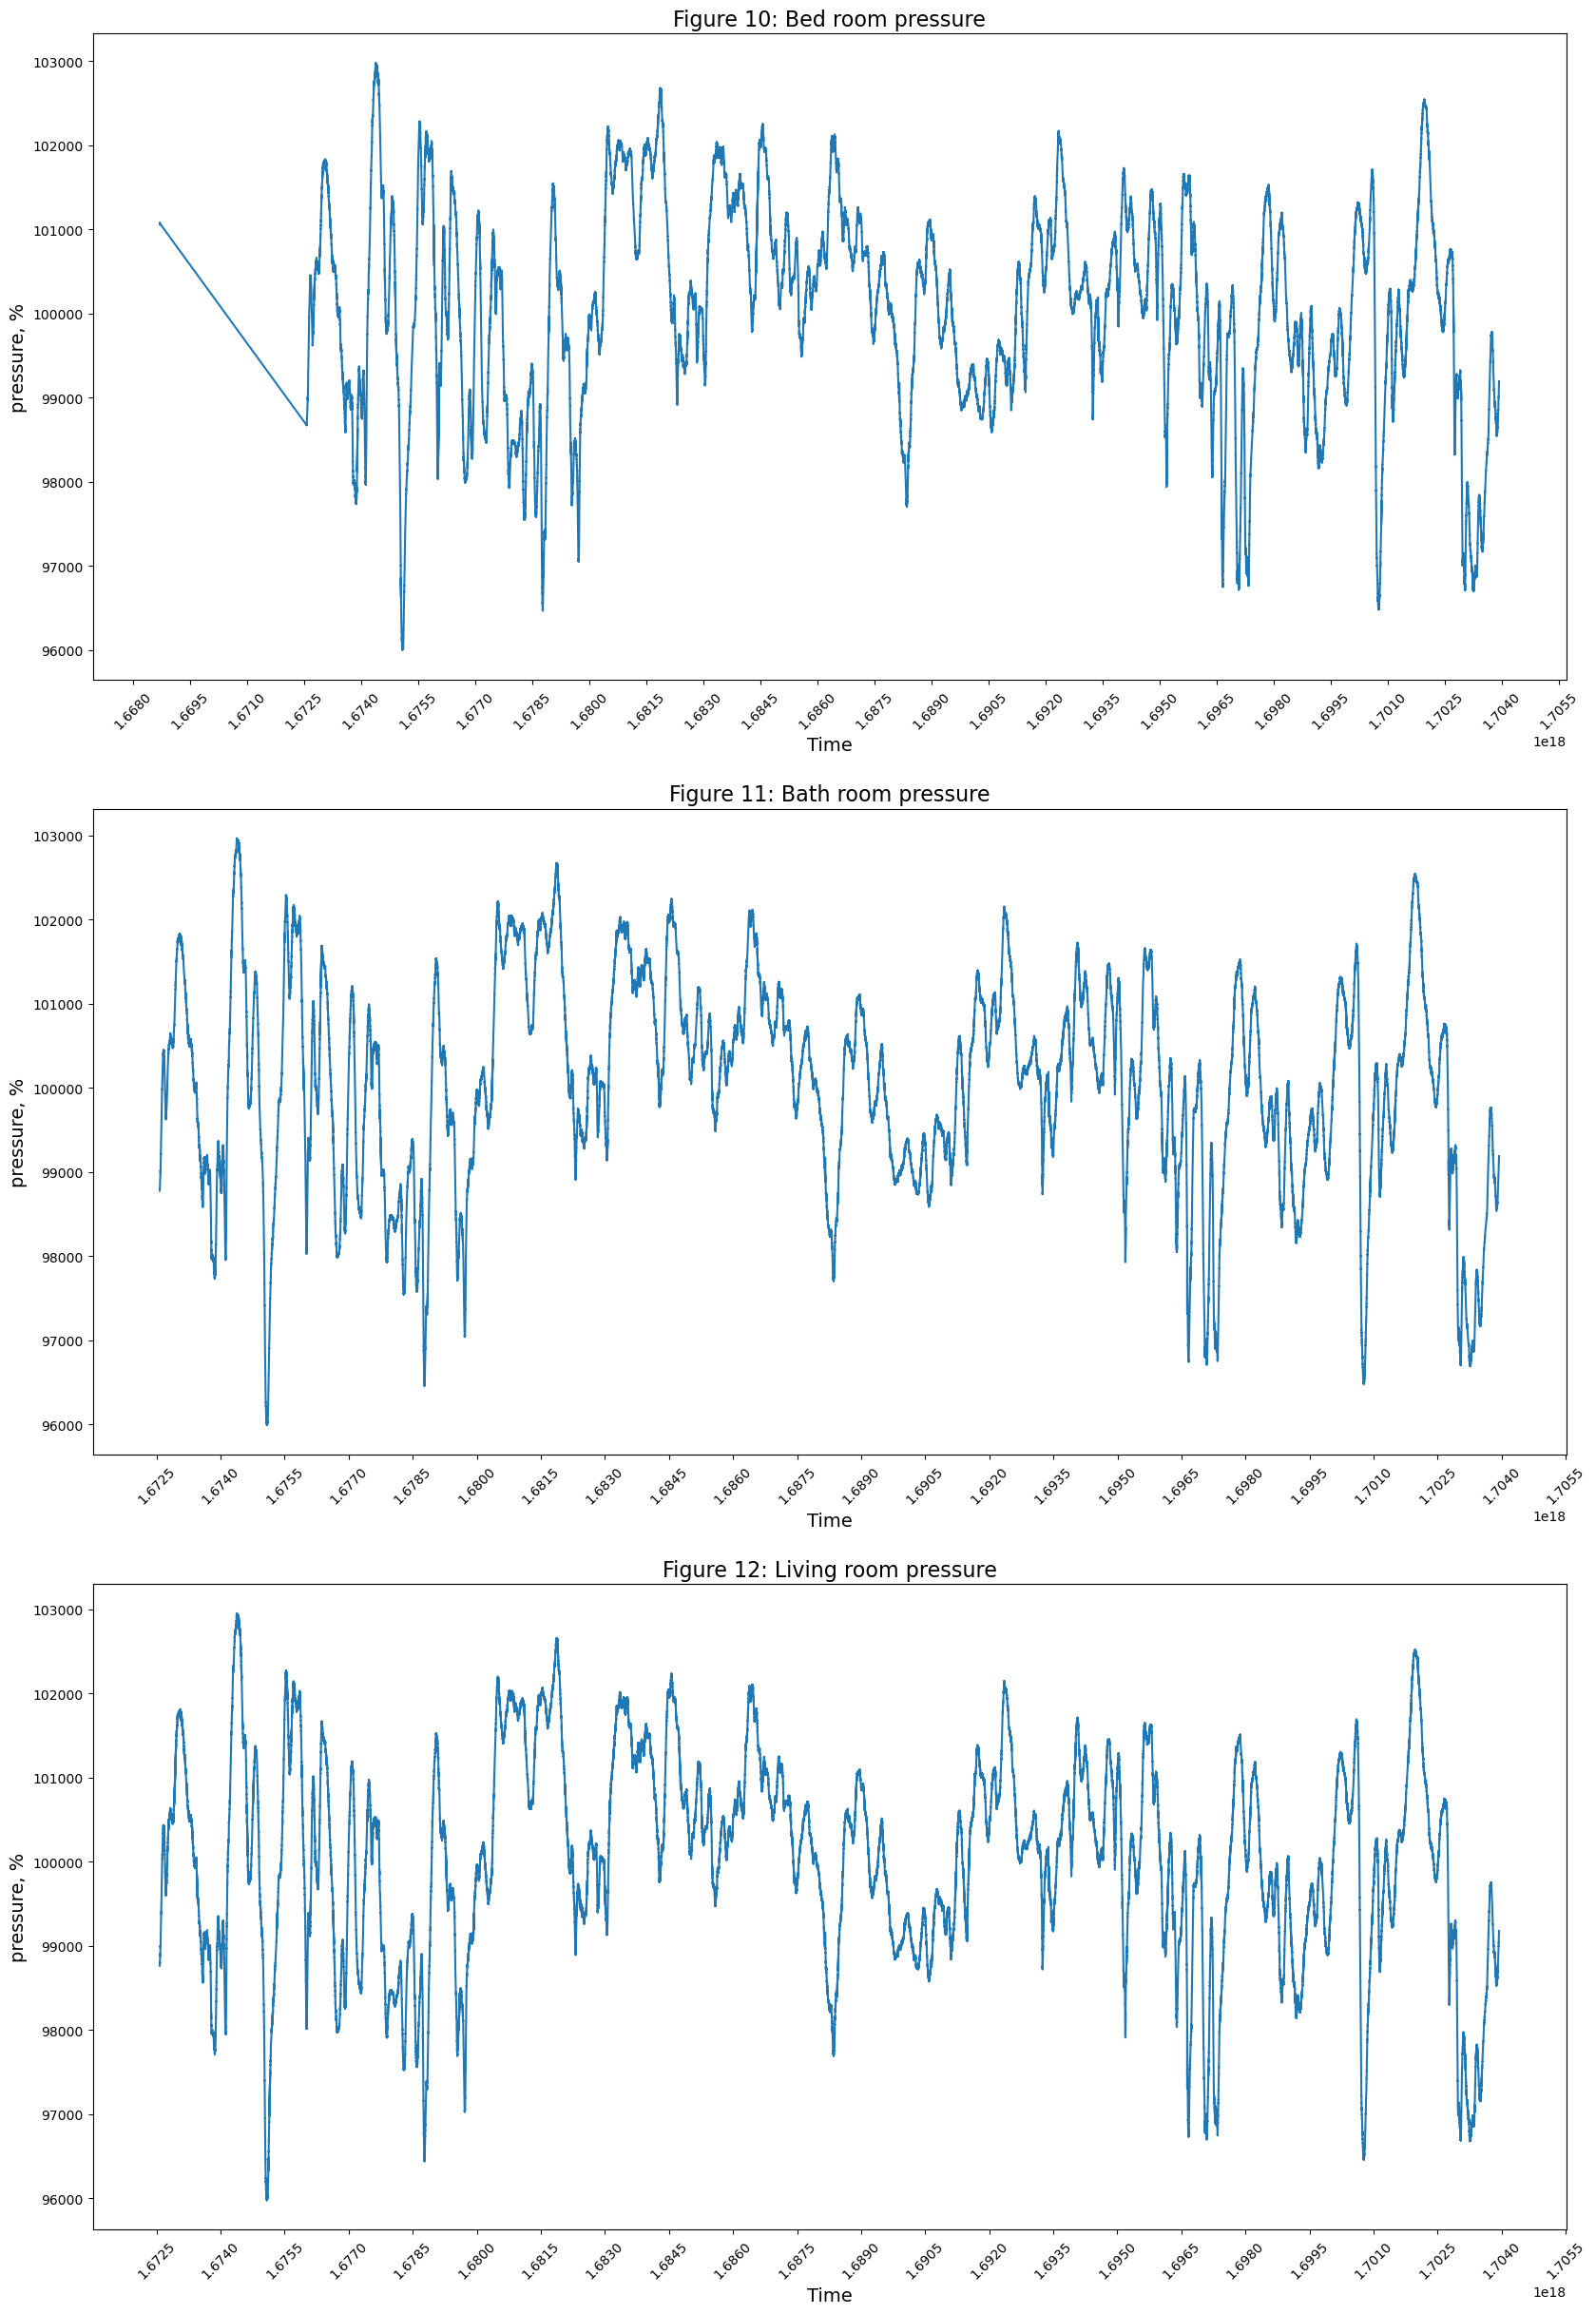

In [21]:
fig, ax = plt.subplots(3,1, figsize=(20, 30))

ax[0].plot(df_a['time'], df_a['pressure'])
ax[0].set_ylabel('pressure, %', size=14)
ax[0].set_xlabel('Time', size=14)
#ax[0].set_xlim('2012-01-01', '2015-12-31')
ax[0].set_title('Figure 10: Bed room pressure', size=16)
ax[0].xaxis.set_major_locator(plt.MaxNLocator(30))
ax[0].tick_params(axis='x', rotation=45)

ax[1].plot(df_b['time'], df_b['pressure'])
ax[1].set_ylabel('pressure, %', size=14)
ax[1].set_xlabel('Time', size=14)
#ax[1].set_xlim('2012-01-01', '2015-12-31')
ax[1].set_title('Figure 11: Bath room pressure', size=16)
ax[1].xaxis.set_major_locator(plt.MaxNLocator(30))
ax[1].tick_params(axis='x', rotation=45)

ax[2].plot(df_c['time'], df_c['pressure'])
ax[2].set_ylabel('pressure, %', size=14)
ax[2].set_xlabel('Time', size=14)
#ax[2].set_xlim('2012-01-01', '2015-12-31')
ax[2].set_title('Figure 12: Living room pressure', size=16)
ax[2].xaxis.set_major_locator(plt.MaxNLocator(30))
ax[2].tick_params(axis='x', rotation=45)


# Adjust layout
#plt.tight_layout()

plt.show()

[Atmospheric pressure](https://en.wikipedia.org/wiki/Atmospheric_pressure) / air pressure is the pressure withing the atmosphere of Earth.

All values are same because all sensors are located in the same geological area.

I could use this to train a regression model which can predict something about next days weather.

Propably I don't need these values but I'll still keep it with just to be sure. Maybe we can try to figure if there is surprising correlations with other columns...

### Visualize sensors battery data

Battery data interests me because I want to predict when I have to change sensors battery.

I think I could train prediction when I have to replace battery :)

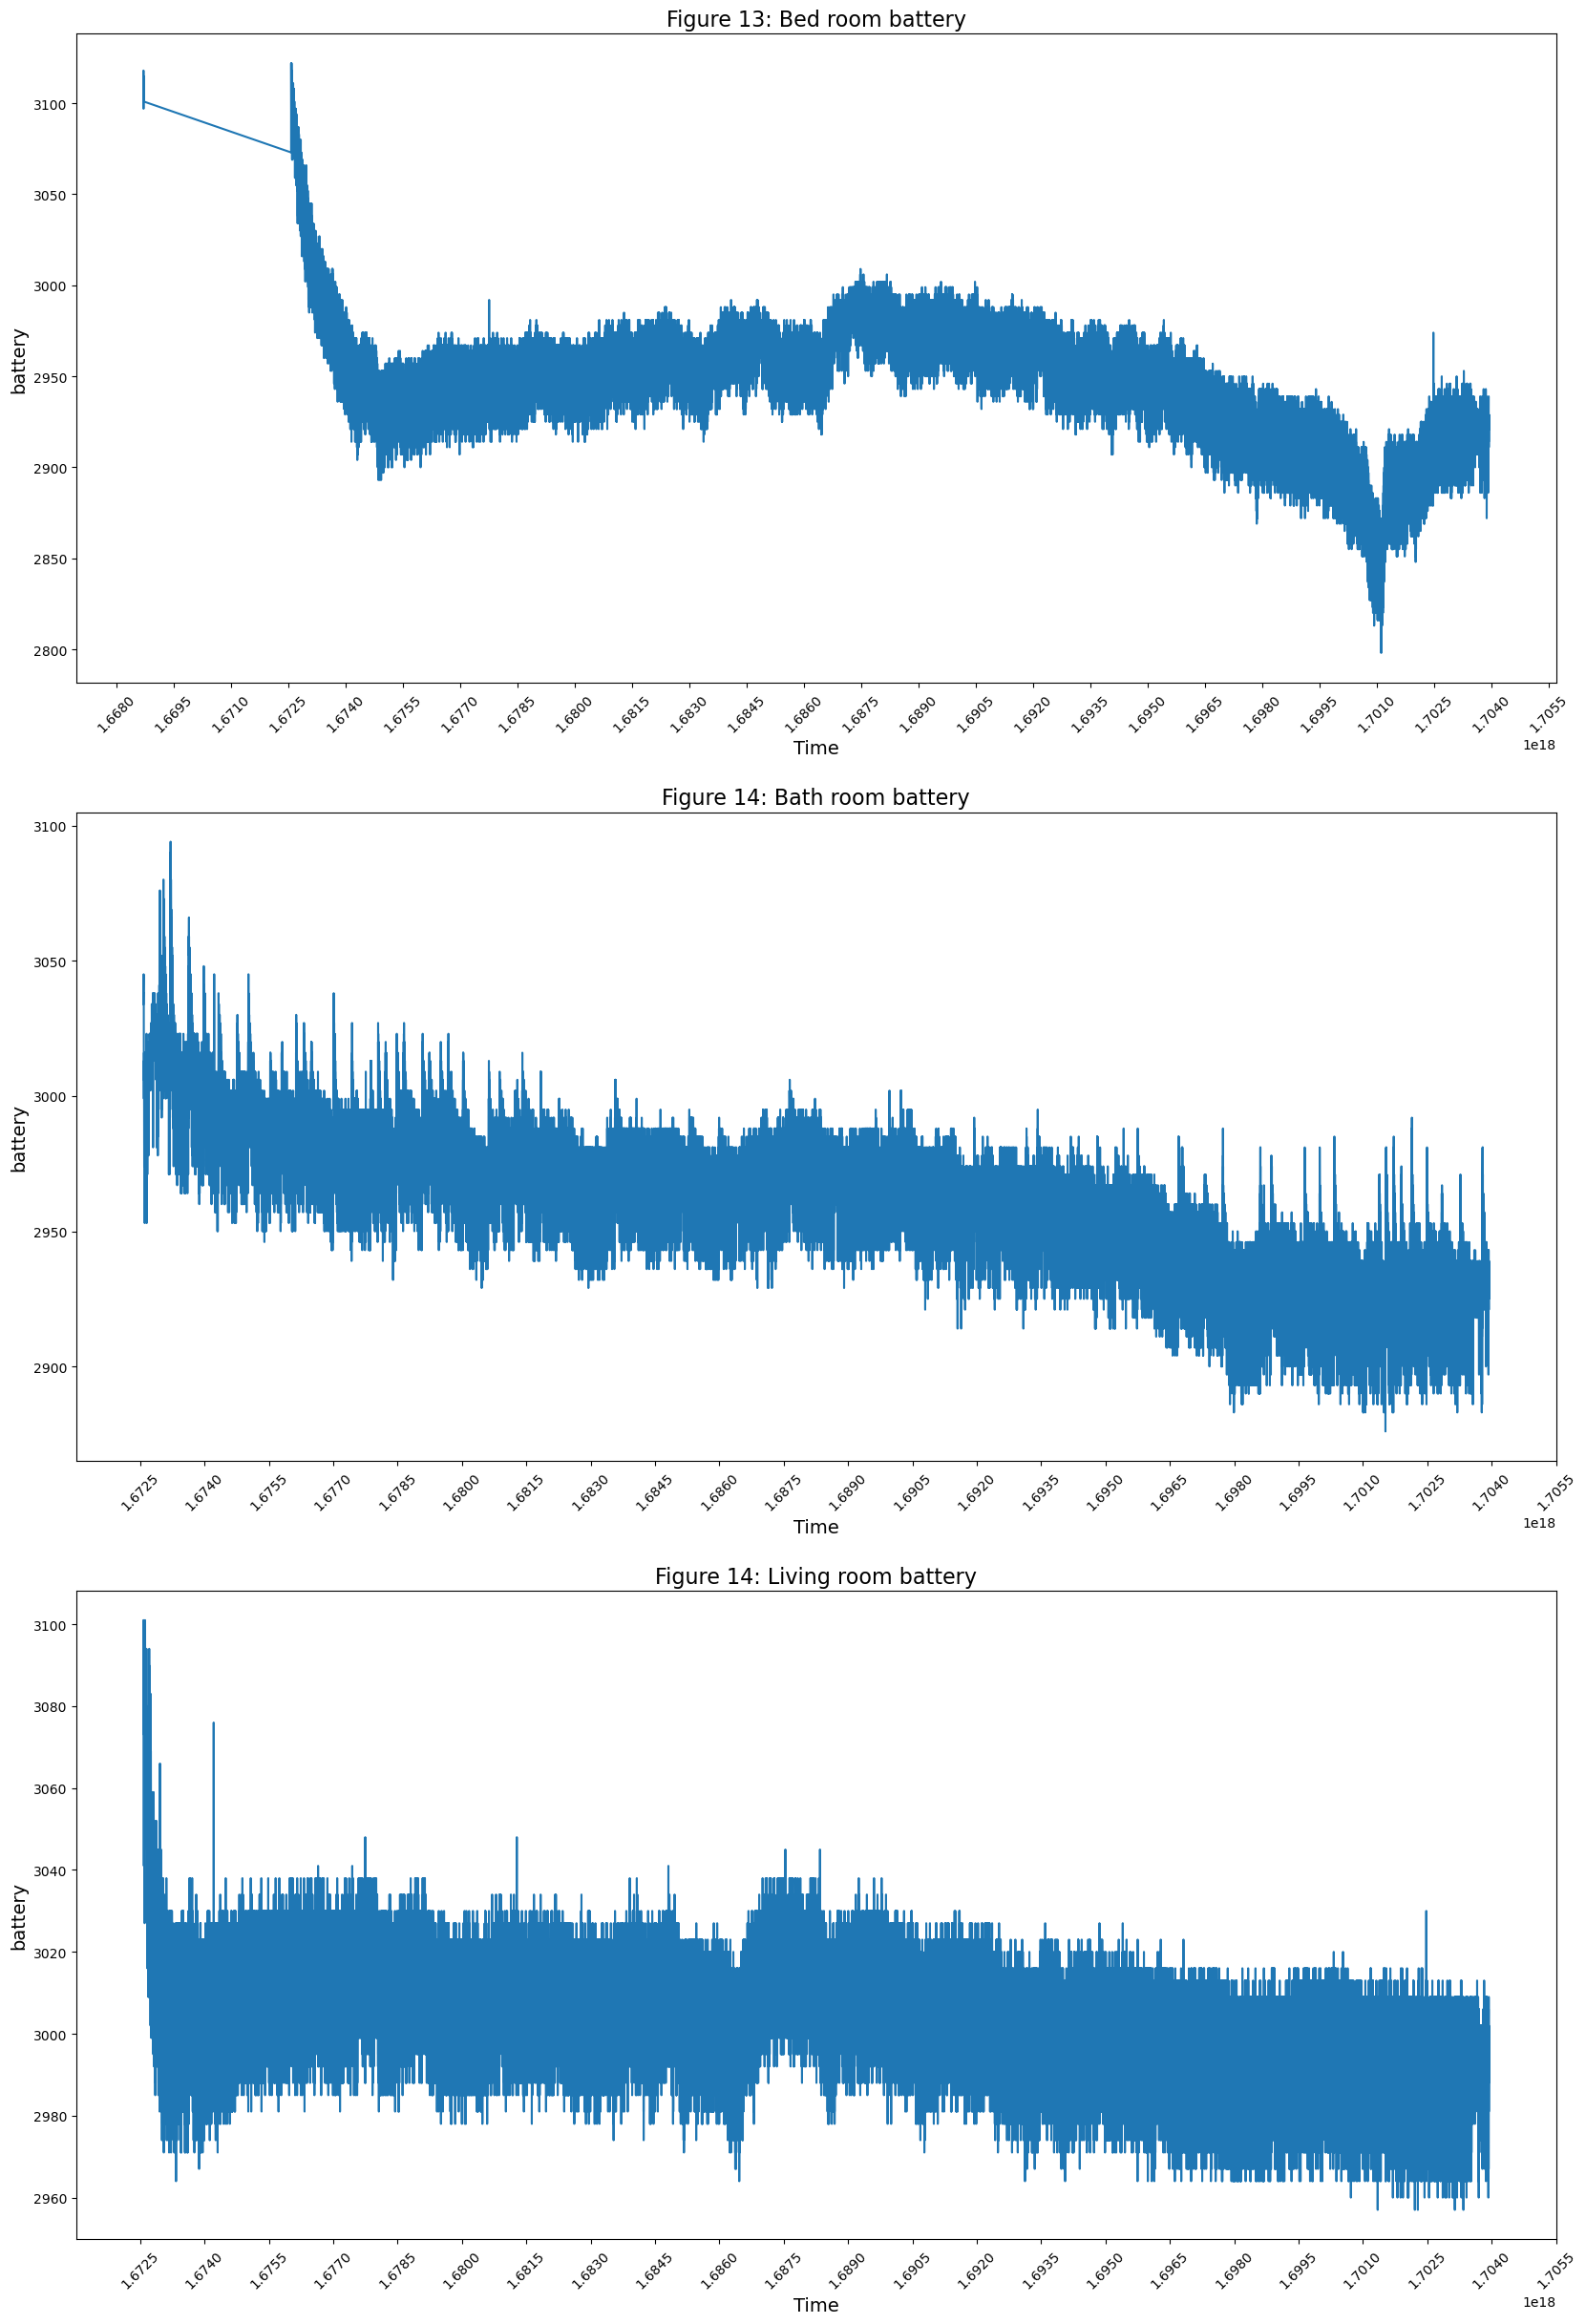

In [22]:
fig, ax = plt.subplots(3,1, figsize=(20, 30))

ax[0].plot(df_a['time'], df_a['battery'])
ax[0].set_ylabel('battery', size=14)
ax[0].set_xlabel('Time', size=14)
ax[0].set_title('Figure 13: Bed room battery', size=16)
ax[0].xaxis.set_major_locator(plt.MaxNLocator(30))
ax[0].tick_params(axis='x', rotation=45)

ax[1].plot(df_b['time'], df_b['battery'])
ax[1].set_ylabel('battery', size=14)
ax[1].set_xlabel('Time', size=14)
#ax[1].set_xlim('2012-01-01', '2015-12-31')
ax[1].set_title('Figure 14: Bath room battery', size=16)
ax[1].xaxis.set_major_locator(plt.MaxNLocator(30))
ax[1].tick_params(axis='x', rotation=45)

ax[2].plot(df_c['time'], df_c['battery'])
ax[2].set_ylabel('battery', size=14)
ax[2].set_xlabel('Time', size=14)
#ax[2].set_xlim('2012-01-01', '2015-12-31')
ax[2].set_title('Figure 14: Living room battery', size=16)
ax[2].xaxis.set_major_locator(plt.MaxNLocator(30))
ax[2].tick_params(axis='x', rotation=45)


# Adjust layout
#plt.tight_layout()

plt.show()

Hmmm... We can see pattern here...

And who is charching batteries on time to time? :D 

Nice.

We see that in figures 3,7,10 and 13 Bed rooms data is something different than in other rooms. At the beginning of the data there is a period where data may have been collected and after that there is no data for along time. Until it has started to be collected again at the same time with other sensors. This data must be deleted.

### Visualize sensors transmitting power data

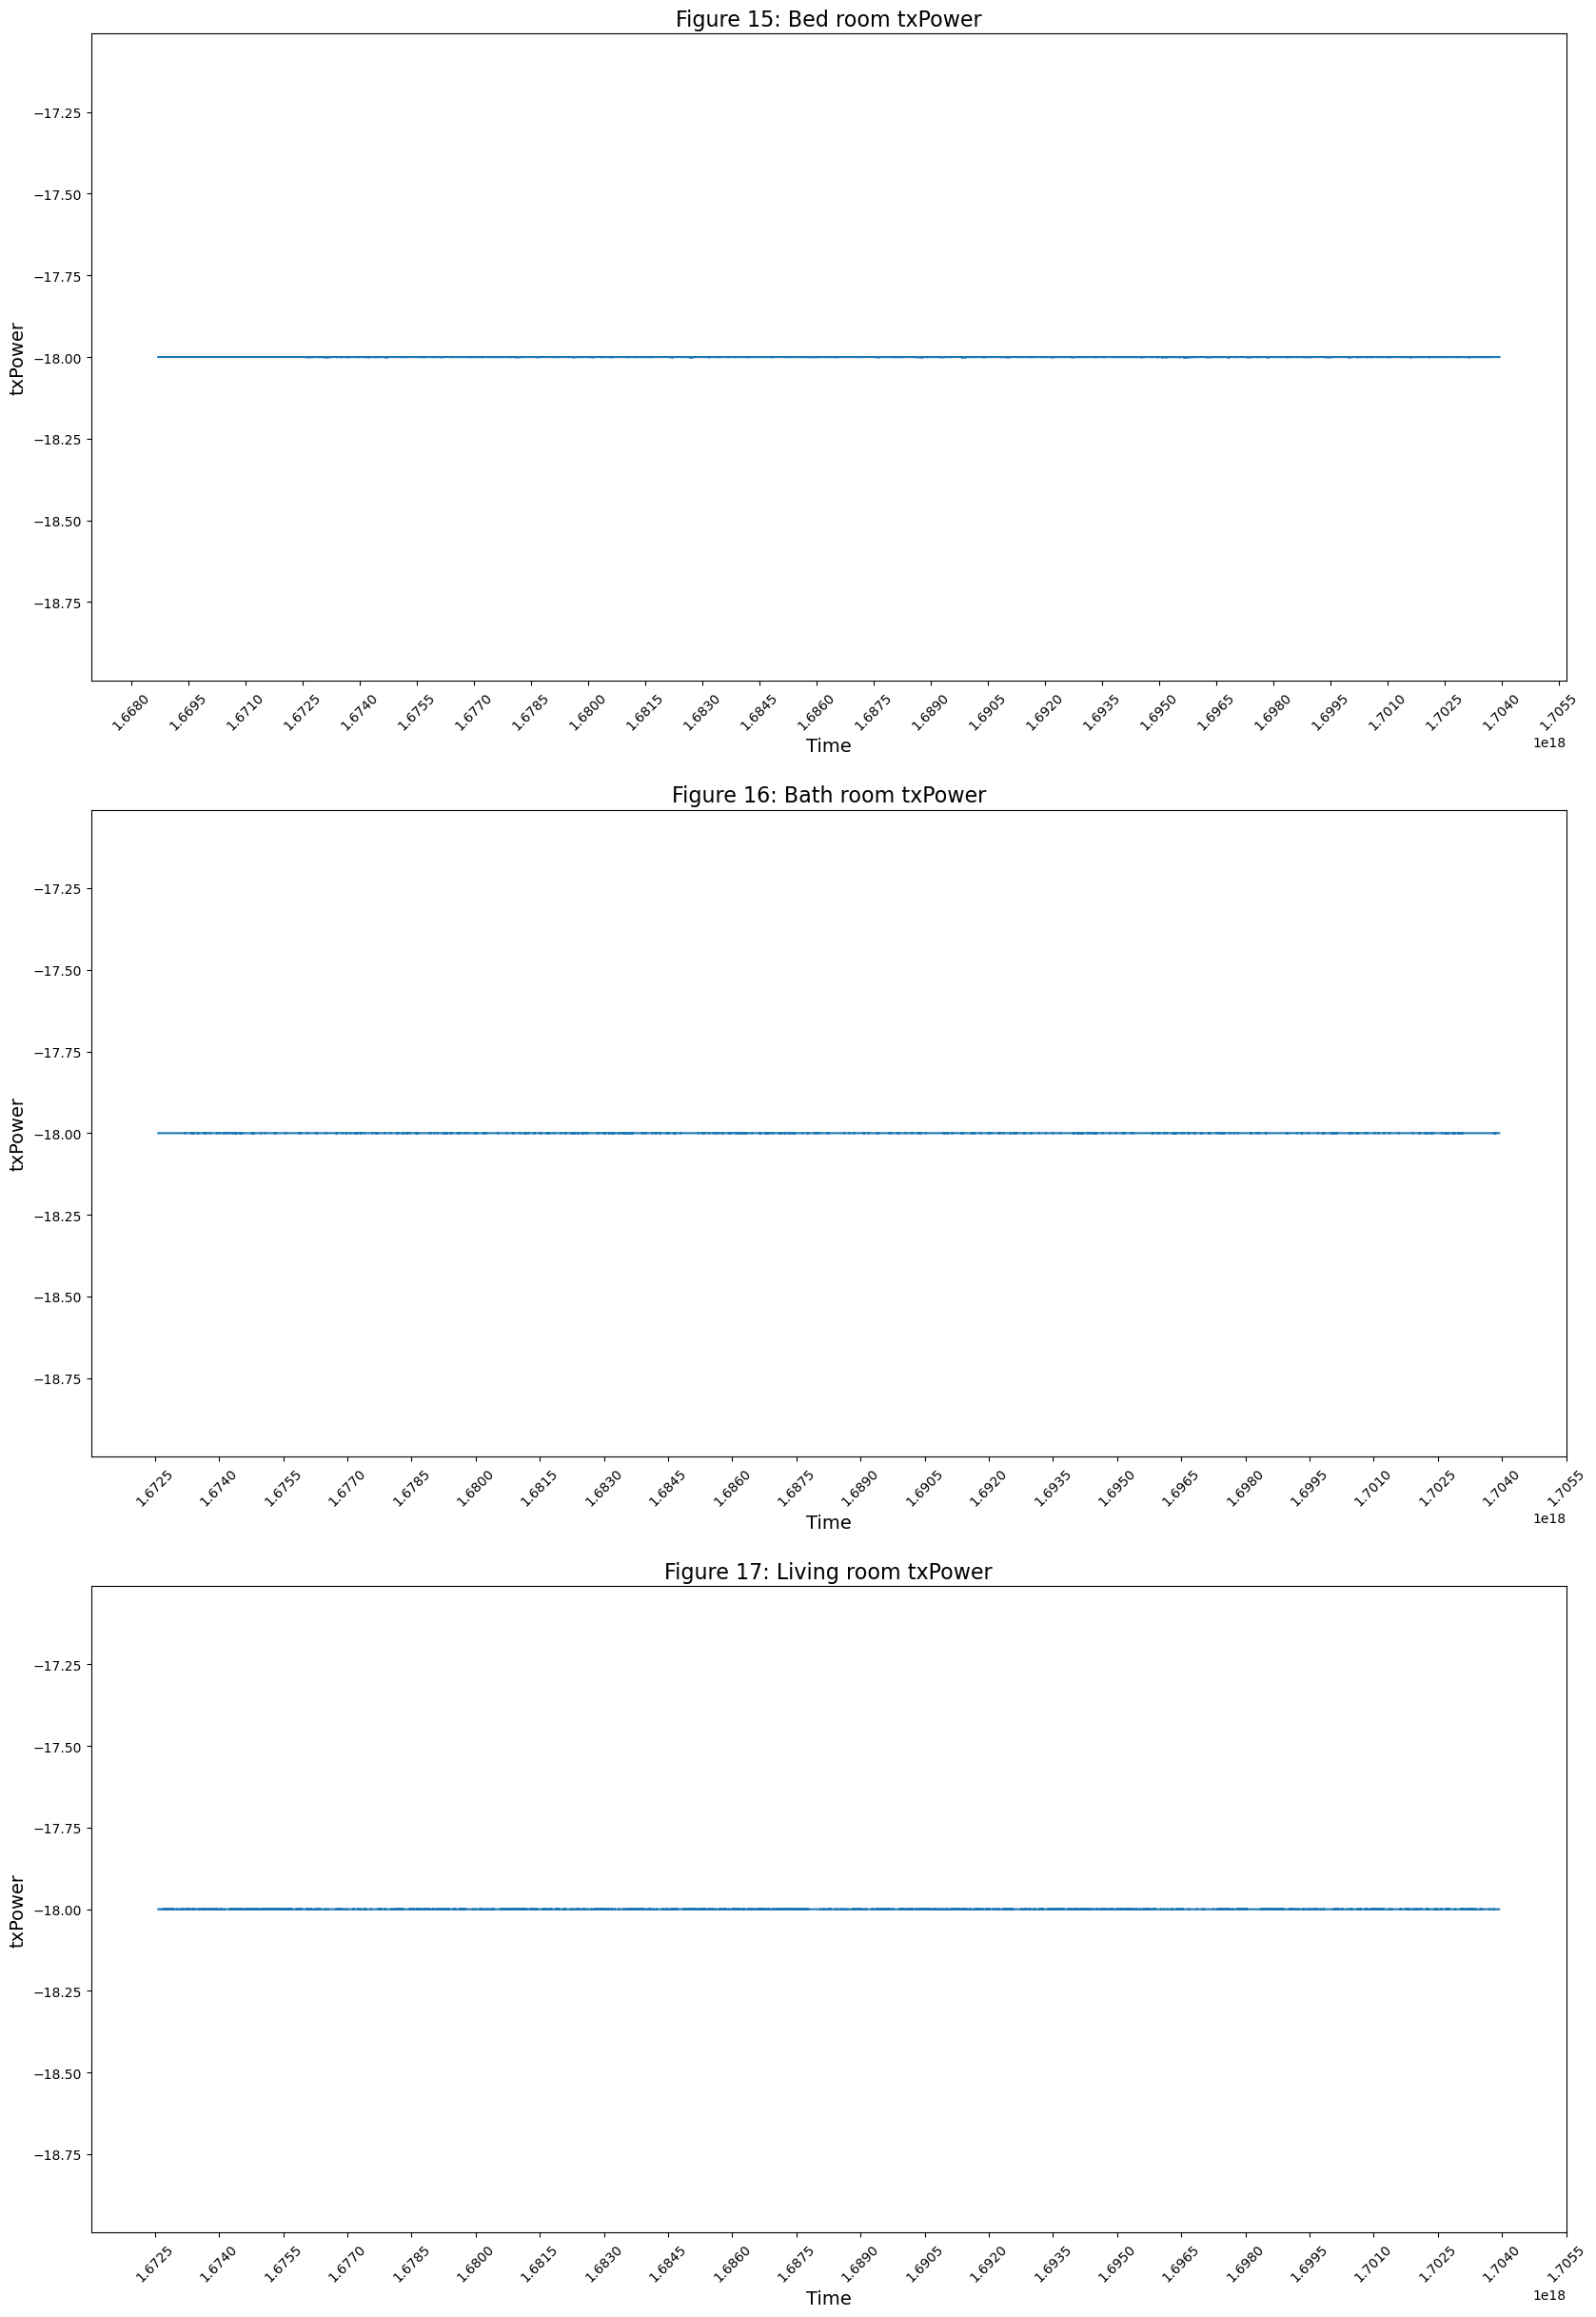

In [23]:
fig, ax = plt.subplots(3,1, figsize=(20, 30))

ax[0].plot(df_a['time'], df_a['txPower'])
ax[0].set_ylabel('txPower', size=14)
ax[0].set_xlabel('Time', size=14)
ax[0].set_title('Figure 15: Bed room txPower', size=16)
ax[0].xaxis.set_major_locator(plt.MaxNLocator(30))
ax[0].tick_params(axis='x', rotation=45)

ax[1].plot(df_b['time'], df_b['txPower'])
ax[1].set_ylabel('txPower', size=14)
ax[1].set_xlabel('Time', size=14)
ax[1].set_title('Figure 16: Bath room txPower', size=16)
ax[1].xaxis.set_major_locator(plt.MaxNLocator(30))
ax[1].tick_params(axis='x', rotation=45)

ax[2].plot(df_c['time'], df_c['txPower'])
ax[2].set_ylabel('txPower', size=14)
ax[2].set_xlabel('Time', size=14)
ax[2].set_title('Figure 17: Living room txPower', size=16)
ax[2].xaxis.set_major_locator(plt.MaxNLocator(30))
ax[2].tick_params(axis='x', rotation=45)


# Adjust layout
#plt.tight_layout()

plt.show()

Jeap. At least there is something that doesn't change. I already knew this because statistic summarys std value was 0.

That's enough for visualization.

Next I will process and modify data and then we will visualize more.

## 3. Data preprocessing

Next I will do all changes and modifications to dataset what I have allready planned in data understanding phase.

Changes and modification are: 

1. Drop row/or fix location if location value does't mach with mac-address.
2. Fill location columns nans by mac-address.
2. Translate location values to english.
3. Change time column format and set it as index.
4. Delete data collected outside of data collection period.


In [24]:
df['mac'].unique()

array(['d7:58:ec:aa:aa:aa', 'd7:58:ec:bb:bb:bb', 'd7:58:ec:cc:cc:cc'],
      dtype=object)

In [25]:
df.isna().sum()

Unnamed: 0            0
name                  0
time                  0
battery               0
humidity              0
location           2311
mac                   0
pressure              0
sequenceCounter    2362
temperature           0
txPower            2362
dtype: int64

### 3.1 Fix, fill nans and translate to english all location values

Update the 'location' column to 'english version for room' for rows where the specified condition is met. 

In [26]:
# if the mac address in question has some other than its correct location value, it will be changed to the correct value.
condition = (df['mac'] == 'd7:58:ec:aa:aa:aa') & (df['location'] != 'Makuuhuone')
df.loc[condition, 'location'] = 'Bed room'

condition = (df['mac'] == 'd7:58:ec:bb:bb:bb') & (df['location'] != 'Pesuhuone')
df.loc[condition, 'location'] = 'Bath room'

condition = (df['mac'] == 'd7:58:ec:cc:cc:cc') & (df['location'] != 'Olohuone')
df.loc[condition, 'location'] = 'Living room'

# change all rest values to enklish
df['location'] = df['location'].replace({'Makuuhuone':'Bed room','Pesuhuone':'Bath room','Olohuone':'Living room'})

In [27]:
df['location'].value_counts()

location
Living room    1091155
Bed room        642088
Bath room       611755
Name: count, dtype: int64

In [28]:
df.isna().sum()

Unnamed: 0            0
name                  0
time                  0
battery               0
humidity              0
location              0
mac                   0
pressure              0
sequenceCounter    2362
temperature           0
txPower            2362
dtype: int64

Check if I can create new dataframes per sensor and see if data looks good.

In [29]:
# New dataframe with only a- sensors data.
df_a = df[df['mac'] == 'd7:58:ec:aa:aa:aa'].copy()
display(df_a['location'].value_counts())

# New dataframe with only b- sensors data.
df_b = df[df['mac'] == 'd7:58:ec:bb:bb:bb'].copy()
display(df_b['location'].value_counts())

# New dataframe with only a- sensors data.
df_c = df[df['mac'] == 'd7:58:ec:cc:cc:cc'].copy()
df_c['location'].value_counts()

location
Bed room    642088
Name: count, dtype: int64

location
Bath room    611755
Name: count, dtype: int64

location
Living room    1091155
Name: count, dtype: int64

Jep! Looks good when in dataframe per sensors has all rows and only one type of location value:) So location column is now ready.

### 3.2 Time column

Time columns format is Unix timestamp. It is easy to convert with to_datetime method.

At first create column named by 'date_time' from conversion of Unix timestamp.

In [30]:
df['date_time'] = pd.to_datetime(df['time'])

In [31]:
display(df[['time','date_time']].head())
display(df[['time','date_time']].tail())

,time,date_time
0,1668699012210029295,2022-11-17 15:30:12.210029295
1,1668699123998784339,2022-11-17 15:32:03.998784339
2,1668699126569181245,2022-11-17 15:32:06.569181245
3,1668699247354987229,2022-11-17 15:34:07.354987229
4,1668699248649418228,2022-11-17 15:34:08.649418228


,time,date_time
2344993,1703937589000000000,2023-12-30 11:59:49
2344994,1703937591000000000,2023-12-30 11:59:51
2344995,1703937715000000000,2023-12-30 12:01:55
2344996,1703937717000000000,2023-12-30 12:01:57
2344997,1703937718000000000,2023-12-30 12:01:58


**Now date_time is in human readable format.**

In [32]:
df.head(1)

,Unnamed: 0,name,time,battery,humidity,location,mac,pressure,sequenceCounter,temperature,txPower,date_time
0,0,msg.payload,1668699012210029295,3104,27.48,Bed room,d7:58:ec:aa:aa:aa,101056,9189.0,18.66,-18.0,2022-11-17 15:30:12.210029295


### 3.3 Change index column to date_time column

Since this is time series data it is better to use it as an index column.

In [33]:
df.set_index('date_time',drop=True,inplace=True)

### Drop unnecessary columns

In [34]:
df.head()

,Unnamed: 0,name,time,battery,humidity,location,mac,pressure,sequenceCounter,temperature,txPower
date_time,,,,,,,,,,,
2022-11-17 15:30:12.210029295,0,msg.payload,1668699012210029295,3104,27.48,Bed room,d7:58:ec:aa:aa:aa,101056,9189.0,18.66,-18.0
2022-11-17 15:32:03.998784339,1,msg.payload,1668699123998784339,3111,27.47,Bed room,d7:58:ec:aa:aa:aa,101059,9233.0,18.63,-18.0
2022-11-17 15:32:06.569181245,2,msg.payload,1668699126569181245,3111,27.47,Bed room,d7:58:ec:aa:aa:aa,101060,9234.0,18.62,-18.0
2022-11-17 15:34:07.354987229,3,msg.payload,1668699247354987229,3104,27.49,Bed room,d7:58:ec:aa:aa:aa,101063,9281.0,18.57,-18.0
2022-11-17 15:34:08.649418228,4,msg.payload,1668699248649418228,3104,27.49,Bed room,d7:58:ec:aa:aa:aa,101063,9281.0,18.57,-18.0


In [35]:
df.drop(['Unnamed: 0', 'name', 'time', 'mac', 'sequenceCounter', 'txPower'],axis=1, inplace=True)

In [36]:
df.head()

,battery,humidity,location,pressure,temperature
date_time,,,,,
2022-11-17 15:30:12.210029295,3104,27.48,Bed room,101056,18.66
2022-11-17 15:32:03.998784339,3111,27.47,Bed room,101059,18.63
2022-11-17 15:32:06.569181245,3111,27.47,Bed room,101060,18.62
2022-11-17 15:34:07.354987229,3104,27.49,Bed room,101063,18.57
2022-11-17 15:34:08.649418228,3104,27.49,Bed room,101063,18.57


### 3.4 Delete unimportand data from year 2022

At firs visualize data per sensors.

In [37]:
# New dataframe with only a- sensors data.
bedR = df[df['location'] == 'Bed room'].copy()
display(bedR['location'].value_counts())

# New dataframe with only b- sensors data.
bathR = df[df['location'] == 'Bath room'].copy()
display(bathR['location'].value_counts())

# New dataframe with only a- sensors data.
livingR = df[df['location'] == 'Living room'].copy()
livingR['location'].value_counts()

location
Bed room    642088
Name: count, dtype: int64

location
Bath room    611755
Name: count, dtype: int64

location
Living room    1091155
Name: count, dtype: int64

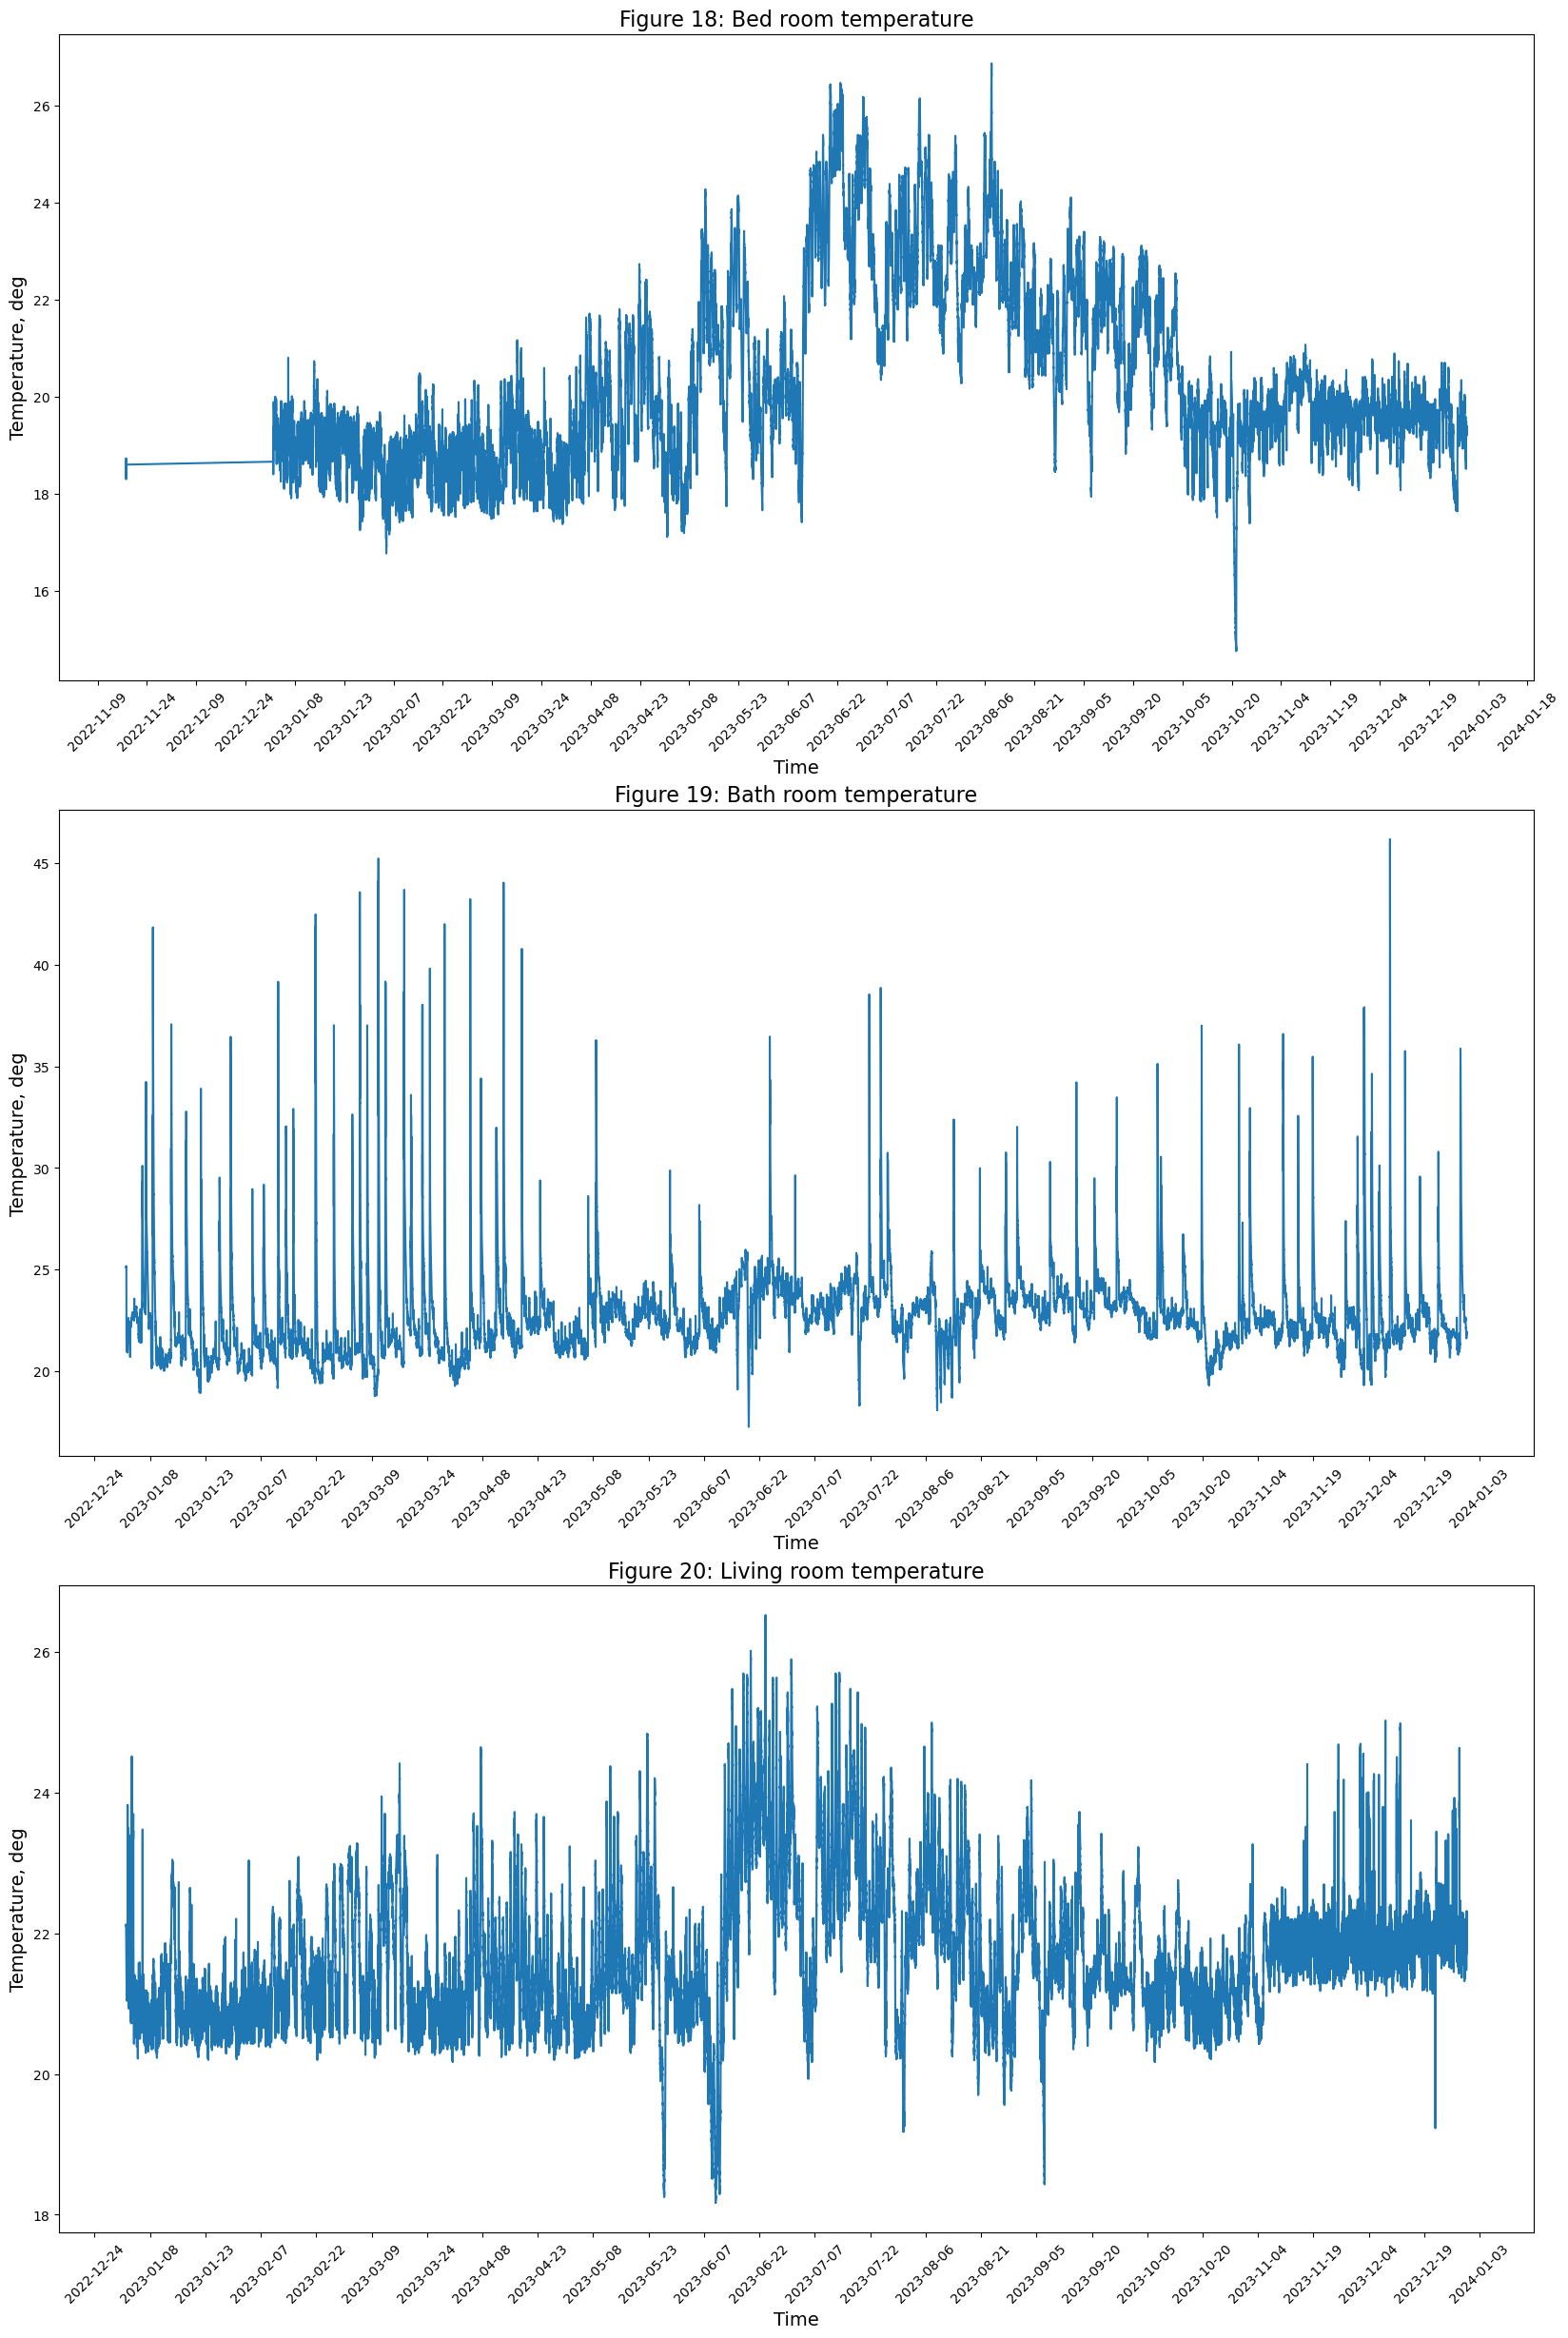

In [38]:
fig, ax = plt.subplots(3,1, figsize=(20, 30))

ax[0].plot(bedR.index, bedR['temperature'])
ax[0].set_ylabel('Temperature, deg', size=14)
ax[0].set_xlabel('Time', size=14)
ax[0].set_title('Figure 18: Bed room temperature', size=16)
ax[0].xaxis.set_major_locator(plt.MaxNLocator(30))
ax[0].tick_params(axis='x', rotation=45)

ax[1].plot(bathR.index, bathR['temperature'])
ax[1].set_ylabel('Temperature, deg', size=14)
ax[1].set_xlabel('Time', size=14)
ax[1].set_title('Figure 19: Bath room temperature', size=16)
ax[1].xaxis.set_major_locator(plt.MaxNLocator(30))
ax[1].tick_params(axis='x', rotation=45)

ax[2].plot(livingR.index, livingR['temperature'])
ax[2].set_ylabel('Temperature, deg', size=14)
ax[2].set_xlabel('Time', size=14)
ax[2].set_title('Figure 20: Living room temperature', size=16)
ax[2].xaxis.set_major_locator(plt.MaxNLocator(30))
ax[2].tick_params(axis='x', rotation=45)


# Adjust layout
#plt.tight_layout()

plt.show()

Now you see that bed rooms data starts in november. But it seems like my project is ready some where around newyear 2023.
Next I'll delete Bed room data before new year 2023.

In [39]:
bedR = bedR[bedR.index > '2022-12-31']

In [40]:
bedR.head()

,battery,humidity,location,pressure,temperature
date_time,,,,,
2023-01-01 09:44:37.680362136,3073,38.83,Bed room,98671,18.66
2023-01-01 09:44:38.957904728,3073,38.31,Bed room,98678,18.70
2023-01-01 09:44:45.387637243,3073,36.66,Bed room,98681,18.80
2023-01-01 09:46:39.747702934,3104,30.75,Bed room,98675,19.37
2023-01-01 09:46:42.319386173,3104,30.75,Bed room,98675,19.39


In [41]:
bathR.head()

,battery,humidity,location,pressure,temperature
date_time,,,,,
2023-01-01 12:25:58,3034,22.55,Bath room,98777,25.12
2023-01-01 12:45:49,3038,22.44,Bath room,98801,25.14
2023-01-01 12:45:57,3038,22.45,Bath room,98794,25.14
2023-01-01 12:49:56,3038,22.41,Bath room,98794,25.13
2023-01-01 13:19:34,3041,22.12,Bath room,98805,25.16


In [42]:
livingR.head()

,battery,humidity,location,pressure,temperature
date_time,,,,,
2023-01-01 12:29:56,3094,27.32,Living room,98763,22.11
2023-01-01 12:35:52,3094,27.27,Living room,98766,22.09
2023-01-01 12:36:01,3094,27.31,Living room,98772,22.13
2023-01-01 12:38:00,3094,27.26,Living room,98769,22.07
2023-01-01 12:39:56,3097,27.27,Living room,98773,22.09


In [43]:
df = df[df.index > '2022-12-31']

### 3.4 Save data to new csv

In [44]:
#url = 'data/ruuvidata_2023_preprocessed.csv'

#df.to_csv(url)

**Next you can open ruuvidata_2023_analyze.ipynb**